In [1]:
import cv2
import io
import sys
import random

import torch

from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

from torch import optim
import torch.nn as nn

#Google drive mounting

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#GPU usage settings

In [3]:
# cuda device setting
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Variables settings

In [4]:
OUT_CH = 4
autoenc_model = 'model_aenc_vqgan_4out_6st.cnn' # the pre-trained model

# set you own variables:
DATA_PATH = '/content/gdrive/MyDrive/Colab Notebooks/NEW_IMAGE_STYLE_GEN/data/'

image_file_name = DATA_PATH + '1_512.jpg'
# auxiliary_image_file_name = image_file_name is also allowed !!!
auxiliary_image_file_name = DATA_PATH + 'w3_512.jpg'

# path to autoencoder:
latent_aenc_model_name = DATA_PATH + autoenc_model

#VQGAN: installation, utility functions, download

The following four code blocks in this section are copied from the Google Colab notebook: https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/reconstruction_usage.ipynb .

MIT License


Copyright (c) 2020 Patrick Esser and Robin Rombach and Björn Ommer

In [5]:
# Copyright (c) 2020 Patrick Esser and Robin Rombach and Björn Ommer
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops>=0.3.0
sys.path.append(".")

!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340 (from 1)
Receiving objects: 100% (1342/1342), 409.77 MiB | 53.16 MiB/s, done.
Resolving deltas: 100% (282/282), done.
/content/taming-transformers


In [6]:
# Copyright (c) 2020 Patrick Esser and Robin Rombach and Björn Ommer
# download a VQGAN with f=16 (16x compression per spatial dimension) and with a larger codebook (16384 entries)
!mkdir -p logs/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_16384/configs
!wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
!wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/configs/model.yaml'

--2024-11-01 15:52:49--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/49f9850c-8d3d-46e0-8042-c11bc9a6081d/last.ckpt [following]
--2024-11-01 15:52:50--  https://heibox.uni-heidelberg.de/seafhttp/files/49f9850c-8d3d-46e0-8042-c11bc9a6081d/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

logs/vqgan_imagenet 100%[===================>] 934.69M  5.78MB/s    in 2m 52s  

2024-11-01 15:55:42 (5.44 MB/s) - ‘logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980092370]

--2024-11-01 15:55:42-- 

###Define some loading and image processing utilities for VQGAN

Note: If you encounter the error ModuleNotFoundError: No module named 'torch._six' in /content/taming-transformers/taming/data/utils.py, open the utils.py file, remove line 11 -  'from torch._six import string_classes', then close the file. After that, re-run the code.



In [8]:
# Copyright (c) 2020 Patrick Esser and Robin Rombach and Björn Ommer
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel

def load_config(config_path):
    config = OmegaConf.load(config_path)
    return config

def load_vqgan(config, ckpt_path=None):
    model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu", weights_only=False)["state_dict"]
        missing, unexpected = model.load_state_dict(sd, strict=False)
    return model.eval()

def preprocess_vqgan(x):
    x = 2.*x - 1.
    return x

def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.)/2.
    x = x.permute(1, 2, 0).numpy()
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

###Load vqgan model:

In [9]:
# Copyright (c) 2020 Patrick Esser and Robin Rombach and Björn Ommer
config_vqgan = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml")
model_vqgan = load_vqgan(config_vqgan, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 220MB/s]


8.19kB [00:00, 614kB/s]                    
/content/taming-transformers/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dic

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


# For all code blocks below:
MIT License

Copyright (c) 2024 OlgaOlmi (Olga Mindlina)

#Latent AutoEncoder model

In [10]:
class LatentEncoder(nn.Module):
    def __init__(self, out_channels):
        super(LatentEncoder, self).__init__()
        nc1 = 64
        nc2 = 1024
        nc3 = 2048
        self.ln1 = nn.Linear(256, nc3)
        self.ln2 = nn.Linear(nc3, nc2)
        self.ln3 = nn.Linear(nc2, nc1)
        self.ln4 = nn.Linear(nc1, out_channels)
        self.gelu = nn.GELU()

    def forward(self, x):
        y = self.ln1(x)
        y = self.gelu(y)
        y = self.ln2(y)
        y = self.gelu(y)
        y = self.ln3(y)
        y = self.gelu(y)
        y = self.ln4(y)
        return y


class LatentDecoder(nn.Module):
    def __init__(self, in_channels):
        super(LatentDecoder, self).__init__()
        nc1 = 64
        nc2 = 1024
        nc3 = 2048
        self.ln1 = nn.Linear(in_channels, nc1)
        self.ln2 = nn.Linear(nc1, nc2)
        self.ln3 = nn.Linear(nc2, nc3)
        self.ln4 = nn.Linear(nc3, 256)
        self.gelu = nn.GELU()

    def forward(self, x):
        y = self.ln1(x)
        y = self.gelu(y)
        y = self.ln2(y)
        y = self.gelu(y)
        y = self.ln3(y)
        y = self.gelu(y)
        y = self.ln4(y)
        return y


class LatentAutoEncoder(nn.Module):

    def __init__(self, channels):
        super(LatentAutoEncoder, self).__init__()
        self.encoder = LatentEncoder(channels)
        self.decoder = LatentDecoder(channels)

    def forward(self, x):
        y = self.encoder(x)
        out = self.decoder(y)

        return out

###Load my pre-trained autoencoder

In [11]:
net = torch.load(latent_aenc_model_name, weights_only=False)
print("The pre-trained model loaded")

The pre-trained model loaded


In [12]:
net.eval().to(device)

LatentAutoEncoder(
  (encoder): LatentEncoder(
    (ln1): Linear(in_features=256, out_features=2048, bias=True)
    (ln2): Linear(in_features=2048, out_features=1024, bias=True)
    (ln3): Linear(in_features=1024, out_features=64, bias=True)
    (ln4): Linear(in_features=64, out_features=4, bias=True)
    (gelu): GELU(approximate='none')
  )
  (decoder): LatentDecoder(
    (ln1): Linear(in_features=4, out_features=64, bias=True)
    (ln2): Linear(in_features=64, out_features=1024, bias=True)
    (ln3): Linear(in_features=1024, out_features=2048, bias=True)
    (ln4): Linear(in_features=2048, out_features=256, bias=True)
    (gelu): GELU(approximate='none')
  )
)

###Utility function: get VQGAN latent space

In [13]:
# get_full_latent returns VQGAN latent space of the image
# the output shape: (1, 1, 1024, 256)
def get_full_latent(file_name):
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = transforms.ToTensor()(img)
    img = transforms.Resize((512, 512))(img)
    img = img.unsqueeze(0)

    with torch.no_grad():
        z, _, [_, _, _] = model_vqgan.encode(preprocess_vqgan(img.to(device)))
    z = z.detach().squeeze(0).cpu()
    z = z.permute(1, 2, 0)
    z = z.reshape((1024, 256))
    z = z.unsqueeze(0)
    z = z.unsqueeze(0)

    return z

#Deterministically changing an image's style by modifying its reduced latent space

### Utility function to display two images: the input and the modified

In [14]:
def show_img(image_file_name, rec):
    img_src = Image.open(image_file_name)
    width, height = img_src.size
    rec = rec.resize((width, height))
    print("            changed image                                                     input image")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    axes[0].imshow(rec)
    axes[1].imshow(img_src)
    plt.show()

###The small latent space modification rules:

In [15]:
# Each of the functions below makes modifications to the reduced latent space:
def mod0(out):
    out[0] = 2*out[0]

def mod1(out):
    out[1] = 2*out[1]

def mod2(out):
    out[2] = 2*out[2]

def mod3(out):
    out[3] = 2*out[3]

def mod4(out):
    out[3] = 0.5*out[3]
    out[2] = 1.5*out[2]
    out[0] = 0.7*out[0]

###The modify_image() function alters the style of the input image according to the rules described in the functions above:

In [16]:
def modify_image(file_name, f_modification):
    # obtain VQGAN latent space
    z = get_full_latent(file_name)

    # obtain small latent space
    with torch.no_grad():
        out = net.encoder(z.to(device))

    # start small latent space modification
    out = out.permute((3, 0, 1, 2))
    # you can try modifications at any indices or combination of indices
    f_modification(out)
    out = out.permute((1, 2, 3, 0))
    # end small latent space modification

    # recontruct VQGAN latent space
    with torch.no_grad():
        out = net.decoder(out.to(device))

    # reconstruct image
    z = torch.reshape(out, (1, 32, 32, 256))
    z = z.permute(0, 3, 1, 2)
    with torch.no_grad():
        im = model_vqgan.decode(z.to(device))

    rec = custom_to_pil(im[0])

    # show images
    show_img(file_name, rec)

            changed image                                                     input image


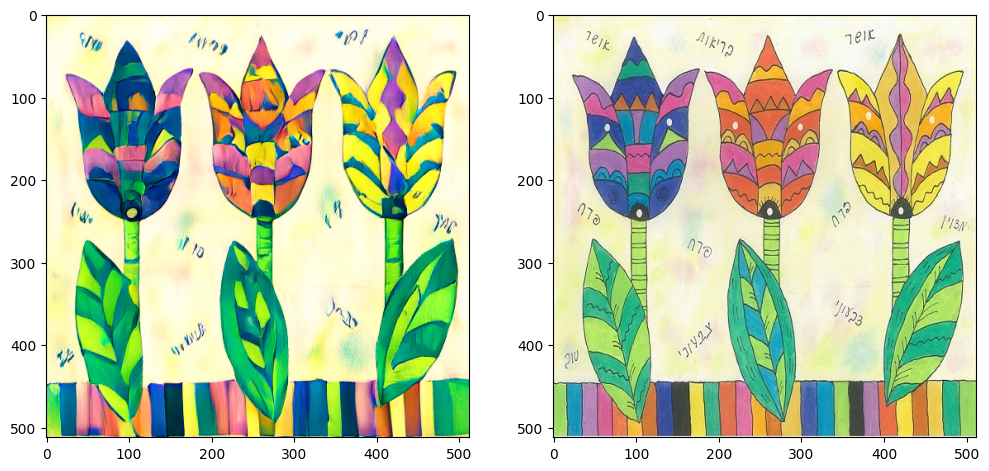

In [41]:
# you can re-set the input files here:
image_file_name = DATA_PATH + '1_512.jpg'

modify_image(image_file_name, mod0)

            changed image                                                     input image


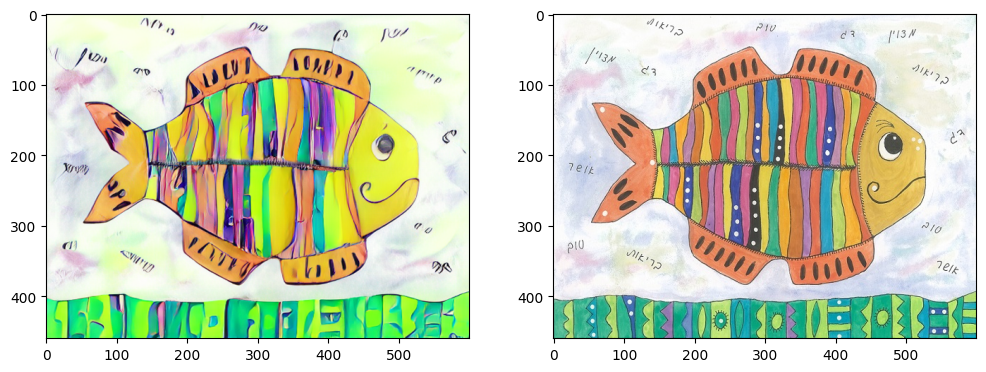

In [38]:
# you can re-set the input files here:
image_file_name = DATA_PATH + '16_600_460.jpg'

modify_image(image_file_name, mod1)

            changed image                                                     input image


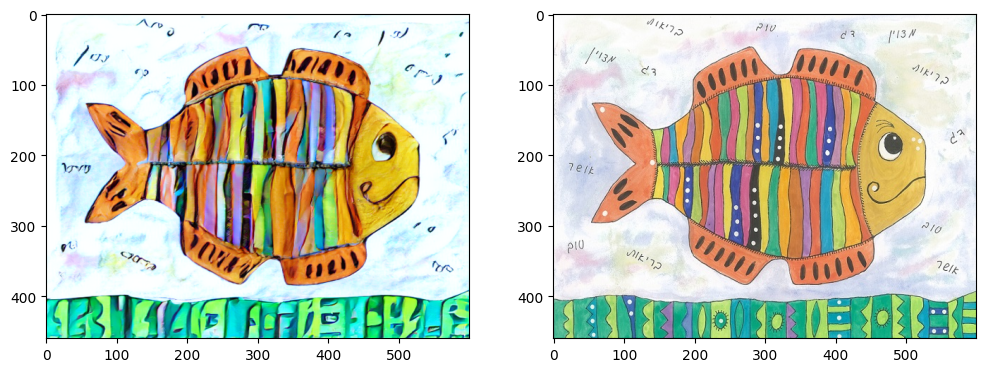

In [39]:
# you can re-set the input files here:
#image_file_name = DATA_PATH + '1_512.jpg'

modify_image(image_file_name, mod2)

            changed image                                                     input image


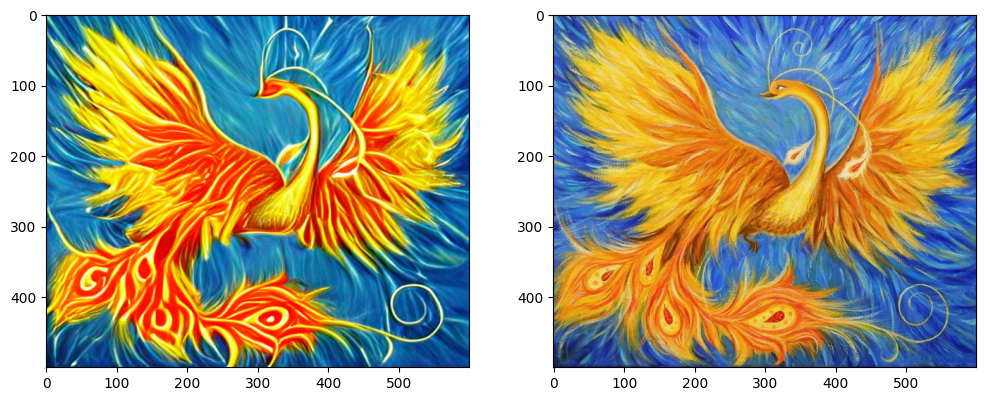

In [40]:
# you can re-set the input files here:
image_file_name = DATA_PATH + '17_600_500.jpg'

modify_image(image_file_name, mod3)

            changed image                                                     input image


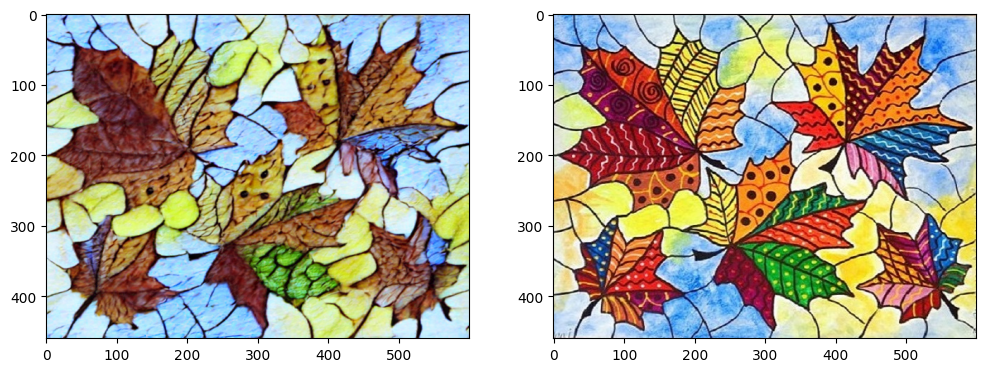

In [23]:
# you can re-set the input files here:
image_file_name = DATA_PATH + '24_600_460.jpg'

modify_image(image_file_name, mod4)

#Try pseudo-training: changing an image's style by pseudo-random modifications to its reduced latent space

###Prepare small latent spaces

In [24]:
def get_data(image_file_name, auxiliary_image_file_name):
    z = get_full_latent(image_file_name)
    z1 = get_full_latent(auxiliary_image_file_name)
    with torch.no_grad():
        out = net.encoder(z.to(device))

    with torch.no_grad():
        outx = net.encoder(z1.to(device))

    out1 = out.permute((0, 3, 1, 2))
    input = torch.reshape(out1, (1, OUT_CH, 32, 32))

    out1x = out.permute((0, 3, 1, 2))
    inputx = torch.reshape(out1x, (1, OUT_CH, 32, 32))

    return input, inputx

### CNN with only one convolution layer

In [25]:
class PseudoNet(nn.Module):
    def __init__(self):
        super(PseudoNet, self).__init__()
        self.conv = nn.Conv2d(OUT_CH, OUT_CH, 3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

###Pseudo-training of the PseudoNet to "reconstruct" the latent space of the input image

In [26]:
def p_train_net(ep_num, image_file_name, auxiliary_image_file_name, pnet_file_name):
    p_net = PseudoNet().to(device)
    p_criterion = nn.MSELoss()
    lr = 0.001
    p_optimizer = optim.Adam(p_net.parameters(), lr=lr)

    min_loss = torch.tensor(10000)
    step_save = -1
    p_optimizer.zero_grad()

    loss_thr = random.uniform(0.27, 0.35)
    zerograd = random.randint(600, 900)
    epoch_thr = 800

    input, inputx = get_data(image_file_name, auxiliary_image_file_name)

    for epoch in range(0, ep_num):

        if epoch % 3 == 0:
            inp = input
        else:
            inp = inputx

        if epoch % zerograd == 0:
            p_optimizer.zero_grad()

        output = p_net(inp)
        loss = p_criterion(output, input)
        loss.backward()
        p_optimizer.step()

        if epoch == epoch_thr:
            if loss.data >= loss_thr:
                min_loss = loss.data
            step_save = epoch
            torch.save(p_net, pnet_file_name)

        if epoch > epoch_thr and min_loss > loss.data and loss.data >= loss_thr:
            min_loss = loss.data
            step_save = epoch
            torch.save(p_net, pnet_file_name)

    print('loss on the image to draw: {}, threshold for loss: {}, step for zero grad: {}, step to save model {}'.format(
                              min_loss.item(), loss_thr, zerograd, step_save))
    return input, min_loss.item()

###Full pipeline including data preparation, pseudo-training and the new image reconstruction.


In [27]:
def train_reconstruct(image_file_name, auxiliary_image_file_name):
    print('wait...')
    pnet_file_name = DATA_PATH + 'best_p_net.cnn'
    step_save = -1
    loss = 10000

    while loss > 0.36:
        input, loss = p_train_net(1020, image_file_name, auxiliary_image_file_name, pnet_file_name)

    p_net = torch.load(pnet_file_name, weights_only=False)
    p_net.eval()

    out = p_net(input)
    out = torch.reshape(out, (1, OUT_CH, 1, 1024))
    out = out.permute((0, 2, 3, 1))

    with torch.no_grad():
        out = net.decoder(out)

    z = torch.reshape(out, (1, 32, 32, 256))
    z = z.permute(0, 3, 1, 2)
    with torch.no_grad():
        im = model_vqgan.decode(z.to(device))

    rec = custom_to_pil(im[0])

    # show images
    show_img(image_file_name, rec)


###To generate a new image just re-run this block:
If the generated image isn't visually appealing, try running the process multiple times. The results are highly random, so repeated attempts may yield something more interesting.

wait...
loss on the image to draw: 0.30130839347839355, threshold for loss: 0.29436660323347397, step for zero grad: 622, step to save model 801
            changed image                                                     input image


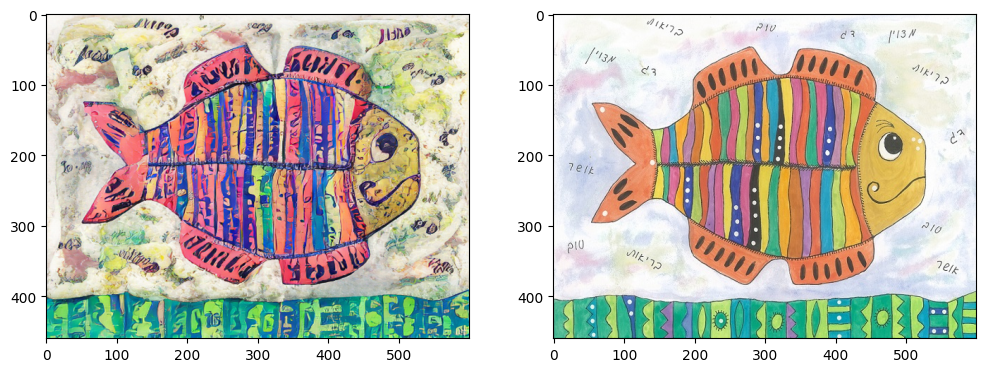

In [36]:
# you can re-set the input files here:
#"""
image_file_name = DATA_PATH + '16_600_460.jpg'
# You can try using different auxiliary image files with the same input file
# to achieve more interesting style variations.
auxiliary_image_file_name = DATA_PATH + 'w3_512.jpg'
#"""

train_reconstruct(image_file_name, auxiliary_image_file_name)